In [1]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.models.tf_ising import TFIChain
from tenpy.tools.params import get_parameter


from tenpy.algorithms import dmrg

# statistics
from scipy.optimize import curve_fit
from scipy import stats

__all__ = ['KitaevLadder', 'Ising1D']

In [20]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        nNNa = [(1, 2, np.array([0])), (3, 0, np.array([1]))]
        nNNb = [(0, 3, np.array([0])), (2, 1, np.array([1]))]
        
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        kwargs['pairs'].setdefault('next_nearest_neighbors_a', nNNa)
        kwargs['pairs'].setdefault('next_nearest_neighbors_b', nNNb)
        
        Lattice.__init__(self, [L], sites, **kwargs)
        

class Ising1D(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', 'parity', self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)
        g = get_parameter(model_params, 'g', 1., self.name, True)
        
        # onsite terms
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(-g, u, 'Sigmaz')

        # coupling terms
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sigmax', u2, 'Sigmax', dx)
#         for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
#             self.add_coupling(-Jx, u1, 'Sz', u2, 'Sz', dx)
#         for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
#             self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
        for u1, u2, dx in self.lat.pairs['next_nearest_neighbors_a']:
            self.add_coupling(-Jz, u1, 'Sigmax', u2, 'Sigmax', dx)
    pass

        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    lat.plot_coupling(ax, lat.pairs['next_nearest_neighbors_a'], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


[None, None, None, None]


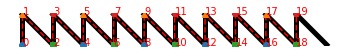

In [21]:
plot_lattice()

In [22]:
def run(calc_correlation=True):

    model_params = dict(conserve='parity', Jz=1., g=1., L=1, verbose=1)
    prod_state = ["up", "up"] * (2 * model_params['L'])
    M = Ising1D(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-4,
            'decay': 1.2,
            'disable_after': 100
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-5,
        'max_sweeps': 10000,
        'verbose': 1.,
    }
    
    
#     eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    # we will return this data dictionary in the end, for the further investigation
    data = dict(
        chi_list=[],
        energy_list=[], 
        entropy_list=[], 
        correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
    chi_list = [int(2**i) for i in np.arange(4, 7, 0.5)]
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Canonicalizing...")
        psi_before = psi.copy()
        psi.canonical_form()
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        
        entropy = np.mean(psi.entanglement_entropy())
        data['entropy_list'].append(entropy)
        
        if calc_correlation:
            correlation = psi.correlation_length()
            data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        pass
        
    return data


In [23]:
def plot_results(data):

    chi_list = data['chi_list']
    energy_list = data['energy_list']
    entropy_list = data['entropy_list']
    correlation_list = data['correlation_list']
    
    plt.plot(chi_list, energy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Ground Energy $E$")
    plt.show()
    
    plt.plot(chi_list, entropy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()
    
    plt.plot(chi_list, correlation_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Correlation Length $\xi$")
    plt.show()
    
    plt.plot(np.log(correlation_list), entropy_list, '-o')
    plt.xlabel(r"log Correlation Length $\xi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()

In [24]:
data = run()

parameter 'verbose'=1 for Ising1D
parameter 'L'=1 for Ising1D
parameter 'conserve'='parity' for Ising1D
parameter 'Jz'=1.0 for Ising1D
parameter 'g'=1.0 for Ising1D


==============================START==============================
Chi =  16 

parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=10000 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-05 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 0.0001, 'decay': 1.2, 'disable_after': 100} for Sweep
Updating environment
.....
sweep 10, age = 204
Energy = -1.2732297456008759, S = nan, norm_err = 1.9e-03
Current memory usage 174.0 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8102e-10, max_E_trunc = 2.2087e-09
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 20

Updating environment
.....
sweep 200, age = 2484
Energy = -1.2732389661186403, S = 0.7621356269385068, norm_err = 1.6e-05
Current memory usage 174.0 MB, time elapsed: 30.7 s
Delta E = 4.6612e-12, Delta S = 2.7171e-05 (per sweep)
max_trunc_err = 3.3785e-08, max_E_trunc = 2.1042e-07
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 210, age = 2604
Energy = -1.2732389660694139, S = 0.7623400791883979, norm_err = 1.2e-05
Current memory usage 174.0 MB, time elapsed: 31.8 s
Delta E = 4.9226e-12, Delta S = 2.0445e-05 (per sweep)
max_trunc_err = 3.3854e-08, max_E_trunc = 2.1085e-07
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 220, age = 2724
Energy = -1.2732389660230865, S = 0.7624935914275580, norm_err = 1.0e-05
Current memory usage 174.0 MB, time elapsed: 32.9 s
Delta E = 4.6327e-12, Delta S = 1.5351e-05 (per sweep)
max_trunc_err = 3.3908e-08, max_E_trunc = 2.1119e-07
MPS bond dimensions: [16, 16, 16, 16]
Updating environment
.....
sweep 230, ag

Updating environment
.....
sweep 150, age = 1884
Energy = -1.2732393449134634, S = 0.7983791285016105, norm_err = 2.2e-05
Current memory usage 174.0 MB, time elapsed: 23.8 s
Delta E = -1.1283e-11, Delta S = 7.1407e-05 (per sweep)
max_trunc_err = 1.0861e-08, max_E_trunc = 7.3392e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 160, age = 2004
Energy = -1.2732393449811070, S = 0.7989605030880577, norm_err = 1.9e-05
Current memory usage 174.0 MB, time elapsed: 24.8 s
Delta E = -6.7644e-12, Delta S = 5.8137e-05 (per sweep)
max_trunc_err = 1.0950e-08, max_E_trunc = 7.3973e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 170, age = 2124
Energy = -1.2732393450141331, S = 0.7994517211100908, norm_err = 1.8e-05
Current memory usage 174.0 MB, time elapsed: 25.9 s
Delta E = -3.3026e-12, Delta S = 4.9122e-05 (per sweep)
max_trunc_err = 1.1026e-08, max_E_trunc = 7.4472e-08
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 180,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
DMRG finished after 260 sweeps.
total size = 3324, maximum chi = 22
Before the canonicalization:
Bond dim =  [22, 22, 22, 22]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000082134664+0j)
After the canonicalization:
Bond dim =  [22, 22, 22, 22]
Computing properties
Optimizing
Loop for chi=22 done.
============================== END ==============================


==============================START==============================
Chi =  32 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -1.2732335557072112, S = nan, norm_err = 6.6e-02
Current memory usage 174.0 MB, time elapsed: 5.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0206e-09, max_E_trunc = 2.0889e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 20, age = 324
Energy = -1.2732380134997001, S = nan, norm_err = 7.0e-03
Current memory usage 174.0 MB, time elapsed: 10.7 s
Delta

Updating environment
.....
sweep 200, age = 2484
Energy = -1.2732395014749613, S = 0.8749850889389682, norm_err = 6.3e-05
Current memory usage 174.0 MB, time elapsed: 47.0 s
Delta E = -3.0252e-11, Delta S = 5.9149e-05 (per sweep)
max_trunc_err = 2.6005e-09, max_E_trunc = 1.7335e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 210, age = 2604
Energy = -1.2732395016399209, S = 0.8736977082425735, norm_err = 6.0e-05
Current memory usage 174.0 MB, time elapsed: 48.1 s
Delta E = -1.6496e-11, Delta S = -1.2874e-04 (per sweep)
max_trunc_err = 2.5492e-09, max_E_trunc = 1.6983e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 220, age = 2724
Energy = -1.2732395016876694, S = 0.8747289918889719, norm_err = 8.9e-05
Current memory usage 174.0 MB, time elapsed: 49.2 s
Delta E = -4.7748e-12, Delta S = 1.0313e-04 (per sweep)
max_trunc_err = 2.4967e-09, max_E_trunc = 1.6643e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 230

Updating environment
.....
sweep 410, age = 5004
Energy = -1.2732395018135776, S = 0.8706356672213569, norm_err = 1.1e-04
Current memory usage 174.0 MB, time elapsed: 70.5 s
Delta E = 1.7656e-11, Delta S = -1.7355e-04 (per sweep)
max_trunc_err = 2.3375e-09, max_E_trunc = 1.5591e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 420, age = 5124
Energy = -1.2732395021573666, S = 0.8710695798812095, norm_err = 4.4e-05
Current memory usage 174.0 MB, time elapsed: 71.9 s
Delta E = -3.4379e-11, Delta S = 4.3391e-05 (per sweep)
max_trunc_err = 2.3321e-09, max_E_trunc = 1.5560e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 430, age = 5244
Energy = -1.2732395020784679, S = 0.8720727276006867, norm_err = 6.1e-05
Current memory usage 174.0 MB, time elapsed: 72.9 s
Delta E = 7.8899e-12, Delta S = 1.0031e-04 (per sweep)
max_trunc_err = 2.3290e-09, max_E_trunc = 1.5541e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 440, 

Updating environment
.....
sweep 620, age = 7524
Energy = -1.2732395019988871, S = 0.8716476935288464, norm_err = 8.1e-05
Current memory usage 174.0 MB, time elapsed: 93.8 s
Delta E = 1.1937e-11, Delta S = 1.2801e-04 (per sweep)
max_trunc_err = 2.3134e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 630, age = 7644
Energy = -1.2732395018126681, S = 0.8699394828310452, norm_err = 1.1e-04
Current memory usage 174.0 MB, time elapsed: 94.9 s
Delta E = 1.8622e-11, Delta S = -1.7082e-04 (per sweep)
max_trunc_err = 2.3192e-09, max_E_trunc = 1.5478e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 640, age = 7764
Energy = -1.2732395021641878, S = 0.8704429077122348, norm_err = 4.6e-05
Current memory usage 174.0 MB, time elapsed: 96.1 s
Delta E = -3.5152e-11, Delta S = 5.0342e-05 (per sweep)
max_trunc_err = 2.3157e-09, max_E_trunc = 1.5463e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 650, 

Updating environment
.....
sweep 830, age = 10044
Energy = -1.2732395019379510, S = 0.8699213217451818, norm_err = 8.5e-05
Current memory usage 174.0 MB, time elapsed: 117.0 s
Delta E = 1.6166e-11, Delta S = -1.5225e-04 (per sweep)
max_trunc_err = 2.3134e-09, max_E_trunc = 1.5454e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 840, age = 10164
Energy = -1.2732395022014771, S = 0.8702288388049522, norm_err = 1.7e-05
Current memory usage 174.0 MB, time elapsed: 118.2 s
Delta E = -2.6353e-11, Delta S = 3.0752e-05 (per sweep)
max_trunc_err = 2.3096e-09, max_E_trunc = 1.5425e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 850, age = 10284
Energy = -1.2732395020857439, S = 0.8714756365094461, norm_err = 5.6e-05
Current memory usage 174.0 MB, time elapsed: 119.3 s
Delta E = 1.1573e-11, Delta S = 1.2468e-04 (per sweep)
max_trunc_err = 2.3136e-09, max_E_trunc = 1.5445e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep

Updating environment
.....
sweep 1040, age = 12564
Energy = -1.2732395019791056, S = 0.8693892449746845, norm_err = 3.8e-05
Current memory usage 174.0 MB, time elapsed: 140.5 s
Delta E = 4.0927e-12, Delta S = -7.2138e-05 (per sweep)
max_trunc_err = 2.3175e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1050, age = 12684
Energy = -1.2732395021489538, S = 0.8704300939496508, norm_err = 7.2e-05
Current memory usage 174.0 MB, time elapsed: 141.7 s
Delta E = -1.6985e-11, Delta S = 1.0408e-04 (per sweep)
max_trunc_err = 2.3246e-09, max_E_trunc = 1.5498e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1060, age = 12804
Energy = -1.2732395021514549, S = 0.8710234251709299, norm_err = 6.9e-05
Current memory usage 174.0 MB, time elapsed: 142.7 s
Delta E = -2.5011e-13, Delta S = 5.9333e-05 (per sweep)
max_trunc_err = 2.3094e-09, max_E_trunc = 1.5420e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

Updating environment
.....
sweep 1250, age = 15084
Energy = -1.2732395019434080, S = 0.8715310427998985, norm_err = 9.0e-05
Current memory usage 174.0 MB, time elapsed: 163.5 s
Delta E = 1.4370e-11, Delta S = 1.4556e-04 (per sweep)
max_trunc_err = 2.3087e-09, max_E_trunc = 1.5425e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1260, age = 15204
Energy = -1.2732395022017045, S = 0.8711356809282701, norm_err = 2.9e-05
Current memory usage 174.0 MB, time elapsed: 164.7 s
Delta E = -2.5830e-11, Delta S = -3.9536e-05 (per sweep)
max_trunc_err = 2.3120e-09, max_E_trunc = 1.5465e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1270, age = 15324
Energy = -1.2732395021344018, S = 0.8701584521597696, norm_err = 5.0e-05
Current memory usage 174.0 MB, time elapsed: 165.8 s
Delta E = 6.7303e-12, Delta S = -9.7723e-05 (per sweep)
max_trunc_err = 2.3108e-09, max_E_trunc = 1.5429e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

Updating environment
.....
sweep 1460, age = 17604
Energy = -1.2732395019365867, S = 0.8715878197907542, norm_err = 8.9e-05
Current memory usage 174.0 MB, time elapsed: 187.2 s
Delta E = 1.6098e-11, Delta S = 1.5208e-04 (per sweep)
max_trunc_err = 2.3095e-09, max_E_trunc = 1.5447e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1470, age = 17724
Energy = -1.2732395021948832, S = 0.8711342523982908, norm_err = 3.9e-05
Current memory usage 174.0 MB, time elapsed: 188.5 s
Delta E = -2.5830e-11, Delta S = -4.5357e-05 (per sweep)
max_trunc_err = 2.3102e-09, max_E_trunc = 1.5432e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 1480, age = 17844
Energy = -1.2732395021225784, S = 0.8701640649226278, norm_err = 5.6e-05
Current memory usage 174.0 MB, time elapsed: 189.5 s
Delta E = 7.2305e-12, Delta S = -9.7019e-05 (per sweep)
max_trunc_err = 2.3116e-09, max_E_trunc = 1.5429e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
s

..........
Updating environment
.....
sweep 10, age = 204
Energy = -1.2732382676466791, S = nan, norm_err = 1.2e-03
Current memory usage 174.0 MB, time elapsed: 4.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8530e-11, max_E_trunc = 1.0829e-10
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 20, age = 324
Energy = -1.2732389139616771, S = nan, norm_err = 8.1e-04
Current memory usage 174.0 MB, time elapsed: 8.3 s
Delta E = -6.4631e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3883e-11, max_E_trunc = 1.7195e-10
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 30, age = 444
Energy = -1.2732391615712686, S = nan, norm_err = 6.0e-04
Current memory usage 174.0 MB, time elapsed: 11.2 s
Delta E = -2.4761e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6560e-11, max_E_trunc = 1.8548e-10
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 40, age = 564
Energy = -1.2732392852853138, S = nan, n

Updating environment
.....
sweep 220, age = 2724
Energy = -1.2732395239828520, S = 0.8603271831355563, norm_err = 1.0e-04
Current memory usage 174.0 MB, time elapsed: 46.9 s
Delta E = -1.1847e-10, Delta S = 3.3227e-04 (per sweep)
max_trunc_err = 2.6237e-10, max_E_trunc = 1.6189e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 230, age = 2844
Energy = -1.2732395250054083, S = 0.8628576580650723, norm_err = 6.4e-05
Current memory usage 174.0 MB, time elapsed: 48.1 s
Delta E = -1.0226e-10, Delta S = 2.5305e-04 (per sweep)
max_trunc_err = 2.7630e-10, max_E_trunc = 1.7017e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 240, age = 2964
Energy = -1.2732395259014879, S = 0.8658912422421176, norm_err = 1.0e-04
Current memory usage 174.0 MB, time elapsed: 49.2 s
Delta E = -8.9608e-11, Delta S = 3.0336e-04 (per sweep)
max_trunc_err = 2.9023e-10, max_E_trunc = 1.7899e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 250,

Updating environment
.....
sweep 430, age = 5244
Energy = -1.2732395318790850, S = 0.8979080605365406, norm_err = 3.4e-05
Current memory usage 174.0 MB, time elapsed: 70.7 s
Delta E = 6.9008e-12, Delta S = 1.0343e-04 (per sweep)
max_trunc_err = 4.9057e-10, max_E_trunc = 3.0022e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 440, age = 5364
Energy = -1.2732395321727381, S = 0.8989930487832946, norm_err = 4.2e-05
Current memory usage 174.0 MB, time elapsed: 71.8 s
Delta E = -2.9365e-11, Delta S = 1.0850e-04 (per sweep)
max_trunc_err = 4.9310e-10, max_E_trunc = 3.0032e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 450, age = 5484
Energy = -1.2732395322310595, S = 0.8998768803014128, norm_err = 3.5e-05
Current memory usage 174.0 MB, time elapsed: 72.8 s
Delta E = -5.8321e-12, Delta S = 8.8383e-05 (per sweep)
max_trunc_err = 4.9659e-10, max_E_trunc = 3.0404e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 460, 

Updating environment
.....
sweep 640, age = 7764
Energy = -1.2732395329569499, S = 0.9123767437852142, norm_err = 3.0e-06
Current memory usage 174.0 MB, time elapsed: 94.2 s
Delta E = -2.7967e-12, Delta S = 4.7582e-05 (per sweep)
max_trunc_err = 5.8781e-10, max_E_trunc = 3.5961e-09
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 650, age = 7884
Energy = -1.2732395329530846, S = 0.9123860599241261, norm_err = 6.9e-06
Current memory usage 174.0 MB, time elapsed: 95.4 s
Delta E = 3.8654e-13, Delta S = 9.3161e-07 (per sweep)
max_trunc_err = 5.8946e-10, max_E_trunc = 3.6034e-09
MPS bond dimensions: [45, 45, 45, 45]
DMRG finished after 650 sweeps.
total size = 7884, maximum chi = 45
Before the canonicalization:
Bond dim =  [45, 45, 45, 45]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000002773356+0j)
After the canonicalization:
Bond dim =  [45, 45, 45, 45]
Computing properties
Optimizing
Loop for chi=45 done.
============================== END ===========

Updating environment
.....
sweep 170, age = 2124
Energy = -1.2732395163149590, S = 0.8410575917054878, norm_err = 1.4e-04
Current memory usage 174.0 MB, time elapsed: 53.1 s
Delta E = -3.3461e-10, Delta S = 4.6223e-04 (per sweep)
max_trunc_err = 1.4625e-11, max_E_trunc = 9.7316e-11
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 180, age = 2244
Energy = -1.2732395191410433, S = 0.8455408937242908, norm_err = 1.3e-04
Current memory usage 174.0 MB, time elapsed: 54.8 s
Delta E = -2.8261e-10, Delta S = 4.4833e-04 (per sweep)
max_trunc_err = 1.6197e-11, max_E_trunc = 1.1141e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 190, age = 2364
Energy = -1.2732395215480210, S = 0.8497246257677646, norm_err = 1.2e-04
Current memory usage 174.0 MB, time elapsed: 56.5 s
Delta E = -2.4070e-10, Delta S = 4.1837e-04 (per sweep)
max_trunc_err = 1.7387e-11, max_E_trunc = 1.2096e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 200,

Updating environment
.....
sweep 380, age = 4644
Energy = -1.2732395375738861, S = 0.9025019437960533, norm_err = 8.0e-05
Current memory usage 174.0 MB, time elapsed: 97.0 s
Delta E = -2.6523e-11, Delta S = 2.1643e-04 (per sweep)
max_trunc_err = 5.3729e-11, max_E_trunc = 3.6016e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 390, age = 4764
Energy = -1.2732395378304773, S = 0.9041396275550805, norm_err = 4.1e-05
Current memory usage 174.0 MB, time elapsed: 99.2 s
Delta E = -2.5659e-11, Delta S = 1.6377e-04 (per sweep)
max_trunc_err = 5.5518e-11, max_E_trunc = 3.8108e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 400, age = 4884
Energy = -1.2732395380916159, S = 0.9057849909063020, norm_err = 3.2e-05
Current memory usage 174.0 MB, time elapsed: 101.1 s
Delta E = -2.6114e-11, Delta S = 1.6454e-04 (per sweep)
max_trunc_err = 5.6552e-11, max_E_trunc = 3.8199e-10
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 410

Updating environment
.....
sweep 20, age = 324
Energy = -1.2728485758233106, S = nan, norm_err = 1.8e-01
Current memory usage 174.0 MB, time elapsed: 12.4 s
Delta E = 3.8831e-05, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7805e-11, max_E_trunc = -2.3175e-10
MPS bond dimensions: [90, 90, 90, 90]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 444
Energy = -1.2732354428912487, S = 0.7505745227918388, norm_err = 9.9e-03
Current memory usage 174.0 MB, time elapsed: 17.5 s
Delta E = -3.8687e-05, Delta S = nan (per sweep)
max_trunc_err = 6.5007e-12, max_E_trunc = -5.4570e-12
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 40, age = 564
Energy = -1.2732391871581825, S = 0.7358068097861632, norm_err = 7.8e-04
Current memory usage 174.0 MB, time elapsed: 22.4 s
Delta E = -3.7443e-07, Delta S = -1.4768e-03 (per sweep)
max_trunc_err = 7.5199e-14, max_E_trunc = 1.2506e-12
MPS bond dimensions: [90

Updating environment
.....
sweep 230, age = 2844
Energy = -1.2732395350755041, S = 0.8804070738275318, norm_err = 1.1e-04
Current memory usage 174.0 MB, time elapsed: 72.3 s
Delta E = -7.1861e-11, Delta S = 3.2881e-04 (per sweep)
max_trunc_err = 3.2676e-12, max_E_trunc = 3.0468e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 240, age = 2964
Energy = -1.2732395357105588, S = 0.8836025675444483, norm_err = 1.1e-04
Current memory usage 174.0 MB, time elapsed: 74.3 s
Delta E = -6.3505e-11, Delta S = 3.1955e-04 (per sweep)
max_trunc_err = 3.4959e-12, max_E_trunc = 3.0468e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 250, age = 3084
Energy = -1.2732395362721718, S = 0.8866373711871602, norm_err = 1.1e-04
Current memory usage 174.0 MB, time elapsed: 76.5 s
Delta E = -5.6161e-11, Delta S = 3.0348e-04 (per sweep)
max_trunc_err = 3.7297e-12, max_E_trunc = 2.9104e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 260,

Updating environment
.....
sweep 440, age = 5364
Energy = -1.2732395411643438, S = 0.9266077257489209, norm_err = 2.8e-05
Current memory usage 174.0 MB, time elapsed: 127.9 s
Delta E = -1.3040e-11, Delta S = 1.6460e-04 (per sweep)
max_trunc_err = 8.8646e-12, max_E_trunc = 6.5484e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 450, age = 5484
Energy = -1.2732395412746200, S = 0.9281241743403366, norm_err = 2.0e-05
Current memory usage 174.0 MB, time elapsed: 131.2 s
Delta E = -1.1028e-11, Delta S = 1.5164e-04 (per sweep)
max_trunc_err = 9.2371e-12, max_E_trunc = 6.6393e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 460, age = 5604
Energy = -1.2732395413933091, S = 0.9296960307379237, norm_err = 2.3e-05
Current memory usage 174.0 MB, time elapsed: 134.4 s
Delta E = -1.1869e-11, Delta S = 1.5719e-04 (per sweep)
max_trunc_err = 9.4862e-12, max_E_trunc = 7.7307e-11
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 4

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
DMRG finished after 630 sweeps.
total size = 7724, maximum chi = 90
Before the canonicalization:
Bond dim =  [90, 90, 90, 90]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000003792512016+0j)
After the canonicalization:
Bond dim =  [90, 90, 90, 90]
Computing properties
Optimizing
Loop for chi=90 done.
============================== END ==============================


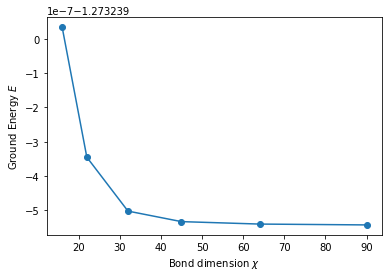

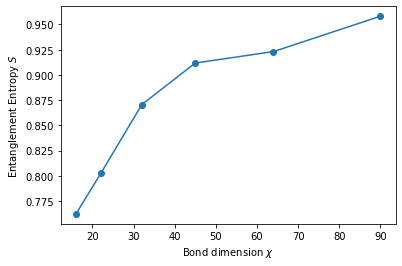

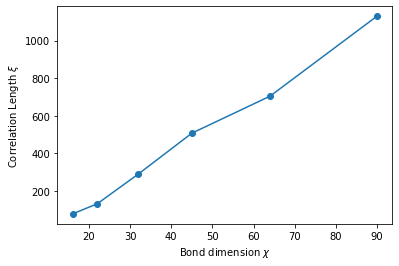

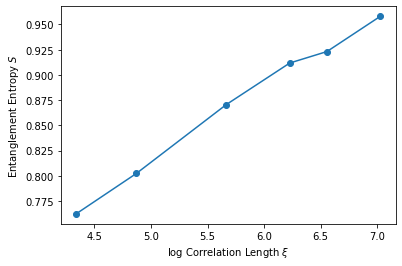

In [25]:
plot_results(data)

In [26]:
chi_list = data['chi_list']
energy_list = data['energy_list']
entropy_list = data['entropy_list']
correlation_list = data['correlation_list']

log_xi = np.log(correlation_list)
s = entropy_list

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, log_xi, s)

print(fitParams)

[0.43898571 0.44840178]


In [9]:
def run_TFI(calc_correlation=True):

    model_params = dict(
        L=2, 
        J=1., 
        g=1., 
        bc_MPS='infinite', 
        conserve='best',
        verbose=0,
        )
    prod_state = ["up"] * model_params['L']
    M = TFIChain(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-8,
        'max_sweeps': 1000,
        'verbose': 1.,
    }
    
    
#     eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    # we will return this data dictionary in the end, for the further investigation
    data = dict(
        chi_list=[],
        energy_list=[], 
        entropy_list=[], 
        correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
    chi_list = [int(2**i) for i in np.arange(4, 7, 0.5)]
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Canonicalizing...")
        psi_before = psi.copy()
        psi.canonical_form()
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        
        entropy = np.mean(psi.entanglement_entropy())
        data['entropy_list'].append(entropy)
        
        if calc_correlation:
            correlation = psi.correlation_length()
            data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        pass
        
    return data


In [10]:
data2=run_TFI()



==============================START==============================
Chi =  16 

parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-08 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732294404668103, S = nan, norm_err = 9.1e-04
Current memory usage 174.0 MB, time elapsed: 1.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2977e-10, max_E_trunc = 2.0405e-09
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2732370232930705, S = nan, norm_err = 5.4e-04
Current memory usage 174.0 MB, time elapsed: 3.5 s
Delta E = -7.5828e-07, Delta S = 0.0000e+00 (per sweep)

Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732389659634578, S = 0.7625091806443471, norm_err = 1.8e-05
Current memory usage 174.0 MB, time elapsed: 15.8 s
Delta E = 7.3214e-12, Delta S = 5.6103e-06 (per sweep)
max_trunc_err = 3.3785e-08, max_E_trunc = 2.1065e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.2732389659751107, S = 0.7626773690686126, norm_err = 1.0e-05
Current memory usage 174.0 MB, time elapsed: 16.3 s
Delta E = -1.1653e-12, Delta S = 1.6819e-05 (per sweep)
max_trunc_err = 3.3830e-08, max_E_trunc = 2.1094e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 230, age = 2840
Energy = -1.2732389658900161, S = 0.7626696668536169, norm_err = 1.0e-05
Current memory usage 174.0 MB, time elapsed: 16.8 s
Delta E = 8.5095e-12, Delta S = -7.7022e-07 (per sweep)
max_trunc_err = 3.3903e-08, max_E_trunc = 2.1139e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 240, age = 2960
Energy = -1.2

Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732389654536291, S = 0.7630674797267314, norm_err = 1.4e-05
Current memory usage 174.0 MB, time elapsed: 27.2 s
Delta E = -6.4915e-12, Delta S = 2.0716e-05 (per sweep)
max_trunc_err = 3.4066e-08, max_E_trunc = 2.1241e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.2732389653168639, S = 0.7628497178436571, norm_err = 5.8e-06
Current memory usage 174.0 MB, time elapsed: 27.7 s
Delta E = 1.3677e-11, Delta S = -2.1776e-05 (per sweep)
max_trunc_err = 3.4148e-08, max_E_trunc = 2.1290e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 440, age = 5360
Energy = -1.2732389653862128, S = 0.7630772049301662, norm_err = 1.5e-05
Current memory usage 174.0 MB, time elapsed: 28.3 s
Delta E = -6.9349e-12, Delta S = 2.2749e-05 (per sweep)
max_trunc_err = 3.4067e-08, max_E_trunc = 2.1242e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 450, age = 5480
Energy = -1.

Updating environment
.....
sweep 630, age = 7640
Energy = -1.2732389649090692, S = 0.7637656869654773, norm_err = 4.7e-05
Current memory usage 174.0 MB, time elapsed: 44.1 s
Delta E = -3.5266e-11, Delta S = -1.5689e-05 (per sweep)
max_trunc_err = 3.4130e-08, max_E_trunc = 2.1260e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 640, age = 7760
Energy = -1.2732389652012444, S = 0.7635869761702239, norm_err = 4.0e-05
Current memory usage 174.0 MB, time elapsed: 44.6 s
Delta E = -2.9218e-11, Delta S = -1.7871e-05 (per sweep)
max_trunc_err = 3.4105e-08, max_E_trunc = 2.1251e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 650, age = 7880
Energy = -1.2732389654438521, S = 0.7634632102529857, norm_err = 3.0e-05
Current memory usage 174.0 MB, time elapsed: 45.1 s
Delta E = -2.4261e-11, Delta S = -1.2377e-05 (per sweep)
max_trunc_err = 3.4074e-08, max_E_trunc = 2.1239e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 660, age = 8000
Energy = 

Updating environment
.....
sweep 840, age = 10160
Energy = -1.2732389657139720, S = 0.7629466382014540, norm_err = 5.8e-06
Current memory usage 174.0 MB, time elapsed: 55.4 s
Delta E = 2.9786e-12, Delta S = -4.9600e-06 (per sweep)
max_trunc_err = 3.4095e-08, max_E_trunc = 2.1259e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 850, age = 10280
Energy = -1.2732389657394378, S = 0.7629987752777219, norm_err = 8.4e-06
Current memory usage 174.0 MB, time elapsed: 55.9 s
Delta E = -2.5466e-12, Delta S = 5.2137e-06 (per sweep)
max_trunc_err = 3.4078e-08, max_E_trunc = 2.1249e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 860, age = 10400
Energy = -1.2732389657073782, S = 0.7629436458312754, norm_err = 5.7e-06
Current memory usage 174.0 MB, time elapsed: 56.4 s
Delta E = 3.2060e-12, Delta S = -5.5129e-06 (per sweep)
max_trunc_err = 3.4097e-08, max_E_trunc = 2.1259e-07
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 870, age = 10520
Energy =

disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 440
Energy = -1.2732392278783635, S = 0.7681182586310779, norm_err = 2.2e-04
Current memory usage 174.0 MB, time elapsed: 4.3 s
Delta E = -7.2888e-09, Delta S = nan (per sweep)
max_trunc_err = 1.8817e-08, max_E_trunc = 6.3011e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 40, age = 560
Energy = -1.2732392776958221, S = 0.7739707069763749, norm_err = 6.9e-05
Current memory usage 174.0 MB, time elapsed: 5.3 s
Delta E = -4.9817e-09, Delta S = 5.8524e-04 (per sweep)
max_trunc_err = 8.9905e-09, max_E_trunc = 6.0562e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 50, age = 680
Energy = -1.2732393141058509, S = 0.7799546143098386, norm_err = 1.0e-04
Current memory usage 174.0 MB, time elapsed: 6.3 s
Delta E = -3.6410e-09, Delta S = 5.9839e-04 (per sweep)
max_trunc_err = 8.8745e-09, max_E_trunc = 6.0153e-08
MPS bond dimensions: [22, 22]
Updating environment


Updating environment
.....
sweep 240, age = 2960
Energy = -1.2732393446499373, S = 0.8014645710197967, norm_err = 1.1e-05
Current memory usage 174.0 MB, time elapsed: 22.3 s
Delta E = 4.3258e-12, Delta S = 6.6447e-05 (per sweep)
max_trunc_err = 1.1316e-08, max_E_trunc = 7.6605e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 250, age = 3080
Energy = -1.2732393167439113, S = 0.8014884393848335, norm_err = 6.0e-05
Current memory usage 174.0 MB, time elapsed: 23.4 s
Delta E = 2.7906e-09, Delta S = 2.3868e-06 (per sweep)
max_trunc_err = 1.1545e-08, max_E_trunc = 7.7876e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 260, age = 3200
Energy = -1.2732393440913938, S = 0.8013469106443760, norm_err = 3.2e-05
Current memory usage 174.0 MB, time elapsed: 23.9 s
Delta E = -2.7347e-09, Delta S = -1.4153e-05 (per sweep)
max_trunc_err = 1.1360e-08, max_E_trunc = 7.6881e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 270, age = 3320
Energy = -1.2

Updating environment
.....
sweep 450, age = 5480
Energy = -1.2732393377918925, S = 0.8019378730614752, norm_err = 6.0e-05
Current memory usage 174.0 MB, time elapsed: 41.1 s
Delta E = -1.4241e-09, Delta S = 4.5100e-06 (per sweep)
max_trunc_err = 1.1636e-08, max_E_trunc = 7.8485e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 460, age = 5600
Energy = -1.2732393413562022, S = 0.8017753009134614, norm_err = 4.0e-05
Current memory usage 174.0 MB, time elapsed: 42.1 s
Delta E = -3.5643e-10, Delta S = -1.6257e-05 (per sweep)
max_trunc_err = 1.1637e-08, max_E_trunc = 7.8437e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 470, age = 5720
Energy = -1.2732393328930129, S = 0.8018771458356767, norm_err = 5.3e-05
Current memory usage 174.0 MB, time elapsed: 43.0 s
Delta E = 8.4632e-10, Delta S = 1.0184e-05 (per sweep)
max_trunc_err = 1.1609e-08, max_E_trunc = 7.8290e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 480, age = 5840
Energy = -1.

Updating environment
.....
sweep 660, age = 8000
Energy = -1.2732393416313244, S = 0.8021412659815582, norm_err = 5.5e-05
Current memory usage 174.0 MB, time elapsed: 60.6 s
Delta E = -2.0831e-09, Delta S = 1.5330e-05 (per sweep)
max_trunc_err = 1.1724e-08, max_E_trunc = 7.9030e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 670, age = 8120
Energy = -1.2732393434305322, S = 0.8021396627382539, norm_err = 3.3e-05
Current memory usage 174.0 MB, time elapsed: 61.4 s
Delta E = -1.7992e-10, Delta S = -1.6032e-07 (per sweep)
max_trunc_err = 1.1457e-08, max_E_trunc = 7.7511e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 680, age = 8240
Energy = -1.2732393444935042, S = 0.8022066275786597, norm_err = 8.3e-06
Current memory usage 174.0 MB, time elapsed: 62.0 s
Delta E = -1.0630e-10, Delta S = 6.6965e-06 (per sweep)
max_trunc_err = 1.1454e-08, max_E_trunc = 7.7496e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 690, age = 8360
Energy = -1

Updating environment
.....
sweep 870, age = 10520
Energy = -1.2732393372959905, S = 0.8017733898633455, norm_err = 3.8e-05
Current memory usage 174.0 MB, time elapsed: 80.0 s
Delta E = -1.1937e-09, Delta S = 1.3041e-05 (per sweep)
max_trunc_err = 1.1533e-08, max_E_trunc = 7.7804e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 880, age = 10640
Energy = -1.2732393359972320, S = 0.8017604488700518, norm_err = 5.4e-05
Current memory usage 174.0 MB, time elapsed: 80.9 s
Delta E = 1.2988e-10, Delta S = -1.2941e-06 (per sweep)
max_trunc_err = 1.1527e-08, max_E_trunc = 7.7767e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 890, age = 10760
Energy = -1.2732393433500420, S = 0.8028349209781197, norm_err = 6.4e-05
Current memory usage 174.0 MB, time elapsed: 81.5 s
Delta E = -7.3528e-10, Delta S = 1.0745e-04 (per sweep)
max_trunc_err = 1.1336e-08, max_E_trunc = 7.6745e-08
MPS bond dimensions: [22, 22]
Updating environment
.....
sweep 900, age = 10880
Energy =

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
DMRG finished after 1000 sweeps.
total size = 12240, maximum chi = 22
Before the canonicalization:
Bond dim =  [22, 22]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999926262676+0j)
After the canonicalization:
Bond dim =  [22, 22]
Computing properties
Optimizing
Loop for chi=22 done.
============================== END ==============================


==============================START==============================
Chi =  32 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732099606599014, S = nan, norm_err = 2.9e-02
Current memory usage 174.0 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1651e-09, max_E_trunc = 1.7752e-09
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2732386305243466, S = nan, norm_err = 4.7e-04
Current memory usage 174.0 MB, time elapsed: 6.1 s
Delta E = -2.8670e-06, Delta 

Updating environment
.....
sweep 200, age = 2480
Energy = -1.2732394977945205, S = 0.8481085906830862, norm_err = 3.6e-05
Current memory usage 174.0 MB, time elapsed: 27.2 s
Delta E = 4.0177e-11, Delta S = 1.8885e-04 (per sweep)
max_trunc_err = 1.8097e-09, max_E_trunc = 1.2248e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732394989106979, S = 0.8499128967412203, norm_err = 2.8e-05
Current memory usage 174.0 MB, time elapsed: 28.3 s
Delta E = -1.1162e-10, Delta S = 1.8043e-04 (per sweep)
max_trunc_err = 1.8419e-09, max_E_trunc = 1.2456e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.2732395003544070, S = 0.8515977441202325, norm_err = 3.5e-05
Current memory usage 174.0 MB, time elapsed: 28.9 s
Delta E = -1.4437e-10, Delta S = 1.6848e-04 (per sweep)
max_trunc_err = 1.8256e-09, max_E_trunc = 1.2378e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 230, age = 2840
Energy = -1.2

Updating environment
.....
sweep 410, age = 5000
Energy = -1.2732395020467493, S = 0.8661596425909471, norm_err = 1.3e-05
Current memory usage 174.0 MB, time elapsed: 46.5 s
Delta E = -1.0850e-10, Delta S = 8.3177e-06 (per sweep)
max_trunc_err = 2.1770e-09, max_E_trunc = 1.4615e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732394985182509, S = 0.8663781489571276, norm_err = 2.0e-05
Current memory usage 174.0 MB, time elapsed: 47.6 s
Delta E = 3.5285e-10, Delta S = 2.1851e-05 (per sweep)
max_trunc_err = 2.2447e-09, max_E_trunc = 1.5015e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.2732395011521476, S = 0.8667656035160385, norm_err = 2.5e-05
Current memory usage 174.0 MB, time elapsed: 48.6 s
Delta E = -2.6339e-10, Delta S = 3.8745e-05 (per sweep)
max_trunc_err = 2.2465e-09, max_E_trunc = 1.5017e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 440, age = 5360
Energy = -1.2

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/linalg/np_conserved.py:4480: UserWarning: SVD with lapack_driver 'gesdd' failed. Use backup 'gesvd'
  U_b, S_b, VH_b = svd_flat(block, full_matrices, True, overwrite_a, check_finite=True)


Updating environment
.....
sweep 550, age = 6680
Energy = -1.2732395007558353, S = 0.8688830497163158, norm_err = 2.5e-05
Current memory usage 174.0 MB, time elapsed: 60.2 s
Delta E = 6.9940e-11, Delta S = -5.1909e-05 (per sweep)
max_trunc_err = 2.3338e-09, max_E_trunc = 1.5587e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 560, age = 6800
Energy = -1.2732394991699039, S = 0.8697860843239895, norm_err = 2.8e-05
Current memory usage 174.0 MB, time elapsed: 61.2 s
Delta E = 1.5859e-10, Delta S = 9.0303e-05 (per sweep)
max_trunc_err = 2.3300e-09, max_E_trunc = 1.5552e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 570, age = 6920
Energy = -1.2732395016280407, S = 0.8697294289966317, norm_err = 1.4e-05
Current memory usage 174.0 MB, time elapsed: 62.2 s
Delta E = -2.4581e-10, Delta S = -5.6655e-06 (per sweep)
max_trunc_err = 2.3420e-09, max_E_trunc = 1.5643e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 580, age = 7040
Energy = -1.

Updating environment
.....
sweep 760, age = 9200
Energy = -1.2732395015123075, S = 0.8700958117932869, norm_err = 2.1e-05
Current memory usage 174.0 MB, time elapsed: 80.6 s
Delta E = -7.9058e-11, Delta S = -5.6685e-06 (per sweep)
max_trunc_err = 2.3720e-09, max_E_trunc = 1.5811e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 770, age = 9320
Energy = -1.2732395018445004, S = 0.8698353136307441, norm_err = 2.1e-05
Current memory usage 174.0 MB, time elapsed: 81.3 s
Delta E = -3.3219e-11, Delta S = -2.6050e-05 (per sweep)
max_trunc_err = 2.3112e-09, max_E_trunc = 1.5458e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 780, age = 9440
Energy = -1.2732394979784658, S = 0.8705206460735710, norm_err = 2.2e-05
Current memory usage 174.0 MB, time elapsed: 82.4 s
Delta E = 3.8660e-10, Delta S = 6.8533e-05 (per sweep)
max_trunc_err = 2.3654e-09, max_E_trunc = 1.5776e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 790, age = 9560
Energy = -1

Updating environment
.....
sweep 970, age = 11720
Energy = -1.2732395021280354, S = 0.8712936975715417, norm_err = 2.3e-05
Current memory usage 174.0 MB, time elapsed: 99.7 s
Delta E = 4.7976e-12, Delta S = 8.9664e-05 (per sweep)
max_trunc_err = 2.3082e-09, max_E_trunc = 1.5454e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 980, age = 11840
Energy = -1.2732395020266267, S = 0.8700795204051487, norm_err = 3.6e-05
Current memory usage 174.0 MB, time elapsed: 100.2 s
Delta E = 1.0141e-11, Delta S = -1.2142e-04 (per sweep)
max_trunc_err = 2.3094e-09, max_E_trunc = 1.5461e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 990, age = 11960
Energy = -1.2732395018217630, S = 0.8717246981429463, norm_err = 5.2e-05
Current memory usage 174.0 MB, time elapsed: 100.7 s
Delta E = 2.0486e-11, Delta S = 1.6452e-04 (per sweep)
max_trunc_err = 2.3061e-09, max_E_trunc = 1.5429e-08
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 1000, age = 12080
Energy 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.72e-05
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12280, maximum chi = 32
Before the canonicalization:
Bond dim =  [32, 32]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000007+0j)
After the canonicalization:
Bond dim =  [32, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================


==============================START==============================
Chi =  45 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732378056921050, S = nan, norm_err = 5.6e-04
Current memory usage 174.0 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2757e-11, max_E_trunc = 2.7228e-11
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 20, ag

Updating environment
.....
sweep 190, age = 2360
Energy = -1.2732395183759309, S = 0.8482500857961264, norm_err = 5.7e-05
Current memory usage 174.0 MB, time elapsed: 23.1 s
Delta E = -1.8598e-10, Delta S = 3.7939e-04 (per sweep)
max_trunc_err = 2.1340e-10, max_E_trunc = 1.3183e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 200, age = 2480
Energy = -1.2732395203897227, S = 0.8517866071773965, norm_err = 5.1e-05
Current memory usage 174.0 MB, time elapsed: 24.0 s
Delta E = -2.0138e-10, Delta S = 3.5365e-04 (per sweep)
max_trunc_err = 2.2703e-10, max_E_trunc = 1.3983e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732395219056798, S = 0.8550499996987677, norm_err = 4.6e-05
Current memory usage 174.0 MB, time elapsed: 24.7 s
Delta E = -1.5160e-10, Delta S = 3.2634e-04 (per sweep)
max_trunc_err = 2.3881e-10, max_E_trunc = 1.4775e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.

Updating environment
.....
sweep 400, age = 4880
Energy = -1.2732395310142692, S = 0.8937135117495143, norm_err = 2.1e-05
Current memory usage 174.0 MB, time elapsed: 41.9 s
Delta E = -4.0848e-11, Delta S = 8.6441e-05 (per sweep)
max_trunc_err = 4.6359e-10, max_E_trunc = 2.8358e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 410, age = 5000
Energy = -1.2732395313635152, S = 0.8951506129256814, norm_err = 2.7e-05
Current memory usage 174.0 MB, time elapsed: 43.0 s
Delta E = -3.4925e-11, Delta S = 1.4371e-04 (per sweep)
max_trunc_err = 4.7379e-10, max_E_trunc = 2.8949e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732395315730400, S = 0.8958973518406661, norm_err = 1.6e-05
Current memory usage 174.0 MB, time elapsed: 44.1 s
Delta E = -2.0952e-11, Delta S = 7.4674e-05 (per sweep)
max_trunc_err = 4.8169e-10, max_E_trunc = 2.9404e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.

Updating environment
.....
sweep 610, age = 7400
Energy = -1.2732395327163886, S = 0.9110198817357742, norm_err = 1.1e-05
Current memory usage 174.0 MB, time elapsed: 66.5 s
Delta E = -6.9963e-11, Delta S = 5.1012e-06 (per sweep)
max_trunc_err = 5.2984e-10, max_E_trunc = 3.4142e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 620, age = 7520
Energy = -1.2732395330904183, S = 0.9116396335823382, norm_err = 3.5e-06
Current memory usage 174.0 MB, time elapsed: 67.2 s
Delta E = -3.7403e-11, Delta S = 6.1975e-05 (per sweep)
max_trunc_err = 5.2070e-10, max_E_trunc = 3.3597e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 630, age = 7640
Energy = -1.2732395330781401, S = 0.9131387335009656, norm_err = 1.5e-05
Current memory usage 174.0 MB, time elapsed: 67.8 s
Delta E = 1.2278e-12, Delta S = 1.4991e-04 (per sweep)
max_trunc_err = 5.2907e-10, max_E_trunc = 3.4015e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 640, age = 7760
Energy = -1.2

Updating environment
.....
sweep 820, age = 9920
Energy = -1.2732395333180193, S = 0.9190882917057435, norm_err = 1.2e-05
Current memory usage 174.0 MB, time elapsed: 84.2 s
Delta E = -7.8876e-11, Delta S = -2.1258e-05 (per sweep)
max_trunc_err = 5.6705e-10, max_E_trunc = 3.6380e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 830, age = 10040
Energy = -1.2732395333025579, S = 0.9198441764771896, norm_err = 5.6e-06
Current memory usage 174.0 MB, time elapsed: 84.8 s
Delta E = 1.5461e-12, Delta S = 7.5588e-05 (per sweep)
max_trunc_err = 5.6904e-10, max_E_trunc = 3.6507e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 840, age = 10160
Energy = -1.2732395332809574, S = 0.9192378143291937, norm_err = 1.4e-05
Current memory usage 174.0 MB, time elapsed: 85.3 s
Delta E = 2.1600e-12, Delta S = -6.0636e-05 (per sweep)
max_trunc_err = 5.6951e-10, max_E_trunc = 3.6598e-09
MPS bond dimensions: [45, 45]
Updating environment
.....
sweep 850, age = 10280
Energy = 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.40e-05
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12280, maximum chi = 45
Before the canonicalization:
Bond dim =  [45, 45]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999959+0j)
After the canonicalization:
Bond dim =  [45, 45]
Computing properties
Optimizing
Loop for chi=45 done.
============================== END ==============================


==============================START==============================
Chi =  64 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732374101735040, S = nan, norm_err = 5.7e-04
Current memory usage 174.0 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0338e-12, max_E_trunc = -2.2453e-12
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 20, 

Updating environment
.....
sweep 190, age = 2360
Energy = -1.2732395213499785, S = 0.8494583464164434, norm_err = 6.1e-05
Current memory usage 174.0 MB, time elapsed: 31.2 s
Delta E = -2.4104e-10, Delta S = 4.2361e-04 (per sweep)
max_trunc_err = 1.7669e-11, max_E_trunc = 1.1914e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 200, age = 2480
Energy = -1.2732395234449996, S = 0.8534494146567958, norm_err = 5.9e-05
Current memory usage 174.0 MB, time elapsed: 32.7 s
Delta E = -2.0950e-10, Delta S = 3.9911e-04 (per sweep)
max_trunc_err = 1.9214e-11, max_E_trunc = 1.3097e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732395252480160, S = 0.8572278075661619, norm_err = 5.5e-05
Current memory usage 174.0 MB, time elapsed: 34.2 s
Delta E = -1.8030e-10, Delta S = 3.7784e-04 (per sweep)
max_trunc_err = 2.1044e-11, max_E_trunc = 1.4688e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.

Updating environment
.....
sweep 400, age = 4880
Energy = -1.2732395380493244, S = 0.9059031710980276, norm_err = 2.2e-05
Current memory usage 174.0 MB, time elapsed: 64.8 s
Delta E = -3.9859e-11, Delta S = 1.7303e-04 (per sweep)
max_trunc_err = 5.7556e-11, max_E_trunc = 3.9472e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 410, age = 5000
Energy = -1.2732395382618051, S = 0.9078478498978673, norm_err = 3.3e-05
Current memory usage 174.0 MB, time elapsed: 66.4 s
Delta E = -2.1248e-11, Delta S = 1.9447e-04 (per sweep)
max_trunc_err = 5.9512e-11, max_E_trunc = 4.0836e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732395385199879, S = 0.9093502793967509, norm_err = 2.6e-05
Current memory usage 174.0 MB, time elapsed: 67.7 s
Delta E = -2.5818e-11, Delta S = 1.5024e-04 (per sweep)
max_trunc_err = 5.9768e-11, max_E_trunc = 4.0473e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.

Updating environment
.....
sweep 610, age = 7400
Energy = -1.2732395403829742, S = 0.9339941246164568, norm_err = 6.8e-06
Current memory usage 174.0 MB, time elapsed: 97.0 s
Delta E = 9.1859e-12, Delta S = 3.3876e-05 (per sweep)
max_trunc_err = 9.2624e-11, max_E_trunc = 6.2755e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 620, age = 7520
Energy = -1.2732395404539147, S = 0.9366485738030716, norm_err = 5.8e-05
Current memory usage 174.0 MB, time elapsed: 98.6 s
Delta E = -7.0941e-12, Delta S = 2.6544e-04 (per sweep)
max_trunc_err = 9.2466e-11, max_E_trunc = 6.2755e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 630, age = 7640
Energy = -1.2732395405178067, S = 0.9357477438289236, norm_err = 2.6e-05
Current memory usage 174.0 MB, time elapsed: 101.2 s
Delta E = -6.3892e-12, Delta S = -9.0083e-05 (per sweep)
max_trunc_err = 9.5529e-11, max_E_trunc = 6.4756e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 640, age = 7760
Energy = -1

Updating environment
.....
sweep 820, age = 9920
Energy = -1.2732395409116180, S = 0.9504355611582355, norm_err = 8.0e-06
Current memory usage 174.0 MB, time elapsed: 132.4 s
Delta E = -2.1009e-11, Delta S = -5.1132e-05 (per sweep)
max_trunc_err = 1.1767e-10, max_E_trunc = 7.9490e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 830, age = 10040
Energy = -1.2732395411123889, S = 0.9520573664333007, norm_err = 4.4e-05
Current memory usage 174.0 MB, time elapsed: 134.2 s
Delta E = -2.0077e-11, Delta S = 1.6218e-04 (per sweep)
max_trunc_err = 1.1905e-10, max_E_trunc = 7.8580e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 840, age = 10160
Energy = -1.2732395408036155, S = 0.9520893797915588, norm_err = 2.7e-05
Current memory usage 174.0 MB, time elapsed: 136.1 s
Delta E = 3.0877e-11, Delta S = 3.2013e-06 (per sweep)
max_trunc_err = 1.2004e-10, max_E_trunc = 8.0036e-10
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 850, age = 10280
Energy

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.02e-05
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12280, maximum chi = 64
Before the canonicalization:
Bond dim =  [64, 64]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000009+0j)
After the canonicalization:
Bond dim =  [64, 64]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================


==============================START==============================
Chi =  90 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 200
Energy = -1.2732369820216860, S = nan, norm_err = 7.8e-04
Current memory usage 174.0 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4739e-12, max_E_trunc = -1.2534e-11
MPS bond dimensions: [90, 90]
Updating en

Updating environment
.....
sweep 190, age = 2360
Energy = -1.2732394905871729, S = 0.8135144035833988, norm_err = 1.0e-04
Current memory usage 174.0 MB, time elapsed: 47.1 s
Delta E = -9.4039e-10, Delta S = 6.7887e-04 (per sweep)
max_trunc_err = 3.5958e-13, max_E_trunc = 6.3665e-12
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 200, age = 2480
Energy = -1.2732394980466779, S = 0.8197659940533089, norm_err = 9.3e-05
Current memory usage 174.0 MB, time elapsed: 48.9 s
Delta E = -7.4595e-10, Delta S = 6.2516e-04 (per sweep)
max_trunc_err = 4.5067e-13, max_E_trunc = 5.4570e-12
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 210, age = 2600
Energy = -1.2732395040616780, S = 0.8255799308058238, norm_err = 8.7e-05
Current memory usage 174.0 MB, time elapsed: 50.5 s
Delta E = -6.0150e-10, Delta S = 5.8139e-04 (per sweep)
max_trunc_err = 5.4913e-13, max_E_trunc = 5.9117e-12
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 220, age = 2720
Energy = -1.

Updating environment
.....
sweep 400, age = 4880
Energy = -1.2732395365974298, S = 0.8932564413148099, norm_err = 1.0e-05
Current memory usage 174.0 MB, time elapsed: 86.7 s
Delta E = -4.0529e-11, Delta S = 1.8761e-04 (per sweep)
max_trunc_err = 4.1805e-12, max_E_trunc = 3.3651e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 410, age = 5000
Energy = -1.2732395371371013, S = 0.8961549622612339, norm_err = 3.6e-05
Current memory usage 174.0 MB, time elapsed: 89.1 s
Delta E = -5.3967e-11, Delta S = 2.8985e-04 (per sweep)
max_trunc_err = 4.3847e-12, max_E_trunc = 3.0923e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 420, age = 5120
Energy = -1.2732395375435317, S = 0.8985071740604942, norm_err = 3.5e-05
Current memory usage 174.0 MB, time elapsed: 90.9 s
Delta E = -4.0643e-11, Delta S = 2.3522e-04 (per sweep)
max_trunc_err = 4.6254e-12, max_E_trunc = 3.8199e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.

Updating environment
.....
sweep 610, age = 7400
Energy = -1.2732395414736857, S = 0.9325429394469280, norm_err = 1.9e-05
Current memory usage 174.0 MB, time elapsed: 129.1 s
Delta E = -1.1164e-11, Delta S = 1.2280e-04 (per sweep)
max_trunc_err = 9.7887e-12, max_E_trunc = 8.3674e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 620, age = 7520
Energy = -1.2732395415439441, S = 0.9339077447644251, norm_err = 6.9e-06
Current memory usage 174.0 MB, time elapsed: 131.5 s
Delta E = -7.0258e-12, Delta S = 1.3648e-04 (per sweep)
max_trunc_err = 1.0302e-11, max_E_trunc = 8.1855e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 630, age = 7640
Energy = -1.2732395416594500, S = 0.9354334422503825, norm_err = 9.8e-06
Current memory usage 174.0 MB, time elapsed: 133.7 s
Delta E = -1.1551e-11, Delta S = 1.5257e-04 (per sweep)
max_trunc_err = 1.0599e-11, max_E_trunc = 7.8217e-11
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 640, age = 7760
Energy = 

Updating environment
.....
sweep 820, age = 9920
Energy = -1.2732395428160999, S = 0.9578387603674732, norm_err = 2.7e-05
Current memory usage 174.0 MB, time elapsed: 168.2 s
Delta E = -4.0700e-12, Delta S = 7.1015e-05 (per sweep)
max_trunc_err = 1.5000e-11, max_E_trunc = 1.0186e-10
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 830, age = 10040
Energy = -1.2732395428583914, S = 0.9589771345189935, norm_err = 2.4e-05
Current memory usage 174.0 MB, time elapsed: 170.1 s
Delta E = -4.2292e-12, Delta S = 1.1384e-04 (per sweep)
max_trunc_err = 1.4980e-11, max_E_trunc = 1.1460e-10
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 840, age = 10160
Energy = -1.2732395428597556, S = 0.9599554397793146, norm_err = 3.8e-05
Current memory usage 174.0 MB, time elapsed: 172.4 s
Delta E = -1.3642e-13, Delta S = 9.7831e-05 (per sweep)
max_trunc_err = 1.5582e-11, max_E_trunc = 1.1096e-10
MPS bond dimensions: [90, 90]
Updating environment
.....
sweep 850, age = 10280
Energy

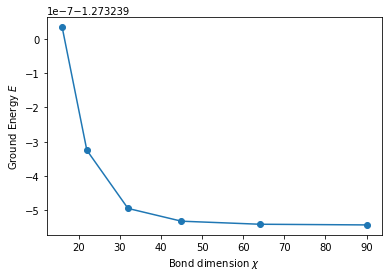

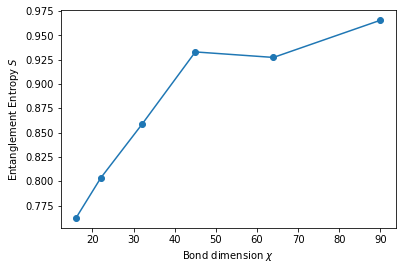

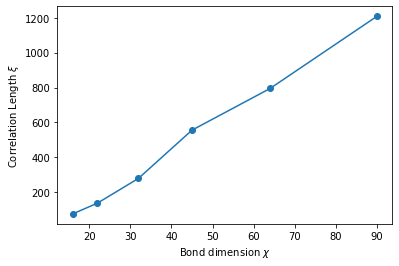

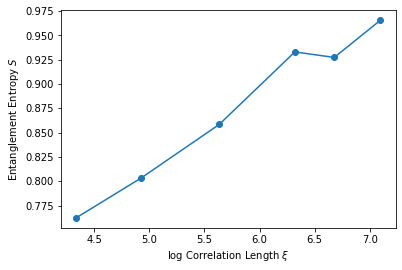

In [11]:
plot_results(data2)

In [12]:
chi_list = data2['chi_list']
energy_list = data2['energy_list']
entropy_list = data2['entropy_list']
correlation_list = data2['correlation_list']

log_xi = np.log(correlation_list)
s = entropy_list

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, log_xi, s)

print(fitParams)

[0.44978893 0.43784362]
